In [1]:
cd drive/My\ Drive/concrete_crack

/content/drive/My Drive/concrete_crack


In [2]:
import numpy as np
import keras.utils
from keras.layers import Input, Dense, Flatten
from keras.models import load_model, Model
from keras.layers import Conv2D, UpSampling2D, AveragePooling2D
from keras.layers import LeakyReLU, Reshape
from keras.datasets import mnist
from keras.models import save_model
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import time

Using TensorFlow backend.


In [0]:
import os

In [0]:
def generateTheta(L,endim):
    # This function generates L random samples from the unit `ndim'-u
    theta=[w/np.sqrt((w**2).sum()) for w in np.random.normal(size=(L,endim))]
    return np.asarray(theta)
def generateZ(batchsize):
    # This function generates 2D samples from a `circle' distribution in 
    # a 2-dimensional space
    r=np.random.uniform(size=(batchsize))
    theta=2*np.pi*np.random.uniform(size=(batchsize))
    x=r*np.cos(theta)
    y=r*np.sin(theta)
    z_=np.array([x,y]).T
    return z_

In [0]:
L = 50
batchsize = 100
endim = 2

In [6]:
img = Input(shape = (28,28,1))
x = Conv2D(16, (3,3), padding = 'same')(img)
x = LeakyReLU(alpha = 0.2)(x)
x = Conv2D(16, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = AveragePooling2D((2,2), padding = 'same')(x) #(none, 14, 14, 16)

x = Conv2D(32, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Conv2D(32, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = AveragePooling2D((2,2), padding = 'same')(x) #(none, 7, 7, 32)

x = Conv2D(64, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Conv2D(64, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = AveragePooling2D((2,2), padding = 'same')(x) #(none, 4, 4, 64)

x = Flatten()(x) #(none, 4*4*64)
x = Dense(128, activation = 'relu')(x)
encoded = Dense(endim)(x)

encoder = Model(inputs = [img], outputs = [encoded])
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4640

In [7]:
embedd = Input(shape = (endim, ))
x = Dense(128)(embedd)
x = Dense(4*4*64, activation = 'relu')(x)
x = Reshape((4,4,64))(x)
x = UpSampling2D((2,2))(x) #(none, 8, 8, 64)

x = Conv2D(64, (3,3), padding='same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Conv2D(64, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = UpSampling2D((2,2))(x) #(none, 16, 16, 64)

x = Conv2D(64, (3,3), padding = 'valid')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Conv2D(64, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = UpSampling2D((2,2))(x) #(none, 28, 28, 64)

x = Conv2D(32, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Conv2D(32, (3,3), padding = 'same')(x)
x = LeakyReLU(alpha = 0.2)(x)
decoded = Conv2D(1, (3,3), padding = 'same', activation = 'sigmoid')(x)

decoder = Model(inputs = [embedd], outputs = [decoded])
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              132096    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 64)          0   

In [0]:
theta=K.variable(generateTheta(L,endim)) #Define a Keras Variable for \theta_ls
z=K.variable(generateZ(batchsize)) #Define a Keras Variable for samples of z

In [9]:
encoded_image = encoder(img)
decoded_image = decoder(encoded_image)
autoencoder = Model(inputs = [img], outputs = [decoded_image])
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 203250    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         308193    
Total params: 511,443
Trainable params: 511,443
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Let projae be the projection of the encoded samples
projae=K.dot(encoded_image,K.transpose(theta))
# Let projz be the projection of the $q_Z$ samples
projz=K.dot(z,K.transpose(theta))
# Calculate the Sliced Wasserstein distance by sorting 
# the projections and calculating the L2 distance between
W2=(tf.nn.top_k(tf.transpose(projae),k=batchsize).values-
    tf.nn.top_k(tf.transpose(projz),k=batchsize).values)**2

In [0]:
proj_encoded_transposed = tf.nn.top_k(tf.transpose(projae), k = batchsize).values
proj_z_transposed = tf.nn.top_k(tf.transpose(projz), k = batchsize).values
w2 = (proj_encoded_transposed - proj_z_transposed)**2
w2weight = K.variable(10.0)
w2loss = w2weight * K.mean(w2)

In [0]:
crossEntropy = K.binary_crossentropy(K.flatten(img), K.flatten(decoded_image))
crossEntropyLoss = (1.0) * K.mean(crossEntropy)

In [0]:
l1Loss = (1.0) * K.mean(K.abs(K.flatten(img) - K.flatten(decoded_image)))

In [0]:
total_loss = w2loss + crossEntropyLoss + l1Loss

In [0]:
autoencoder.add_loss(total_loss)

In [16]:
autoencoder.compile(optimizer = 'rmsprop', loss = '')

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output model_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_2.
  'be expecting any data to be passed to {0}.'.format(name))


In [17]:
cd data_28

/content/drive/My Drive/concrete_crack/data_28


In [18]:
ls

rescaled_negative_data.npy  X_test_negative.npy
rescaled_positive_data.npy  X_test_positive_balanced.npy
X_test_balanced.npy         X_test_positive_imbalanced.npy
X_test_imbalanced.npy       X_train.npy


In [0]:
X_train = np.load('X_train.npy', allow_pickle=True)

In [0]:
X_test_balanced = np.load('X_test_balanced.npy', allow_pickle=True)

In [0]:
X_test_imbalanced = np.load('X_test_imbalanced.npy', allow_pickle=True)

In [22]:
history = autoencoder.fit(X_train, None, validation_split=0.2, epochs = 1, batch_size = 100)

Train on 12800 samples, validate on 3200 samples
Epoch 1/1
12800/12800 [==============================] - 12s 956us/step - loss: 2.2726 - val_loss: 1.6998


In [0]:
encoded = encoder.predict(X_train)

In [24]:
encoded.shape

(16000, 2)

In [0]:
z = generateZ(16000)

In [26]:
z.shape

(16000, 2)

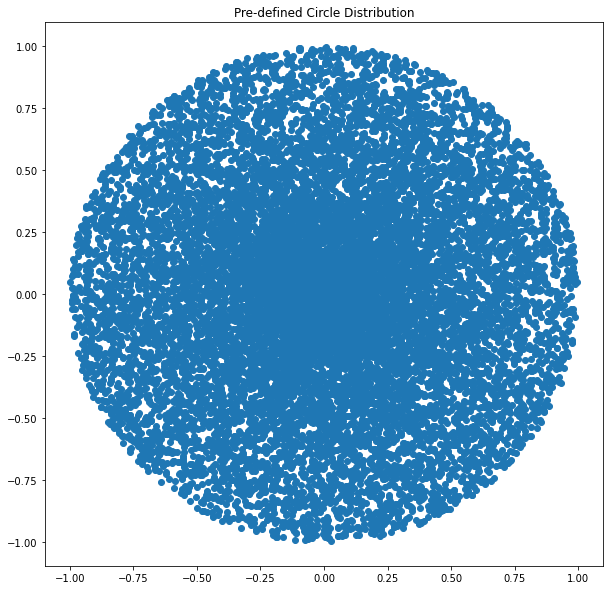

In [27]:
plt.figure(figsize = (10, 10))
plt.scatter(z[:, 0], z[:, 1])
plt.title('Pre-defined Circle Distribution')
plt.show()

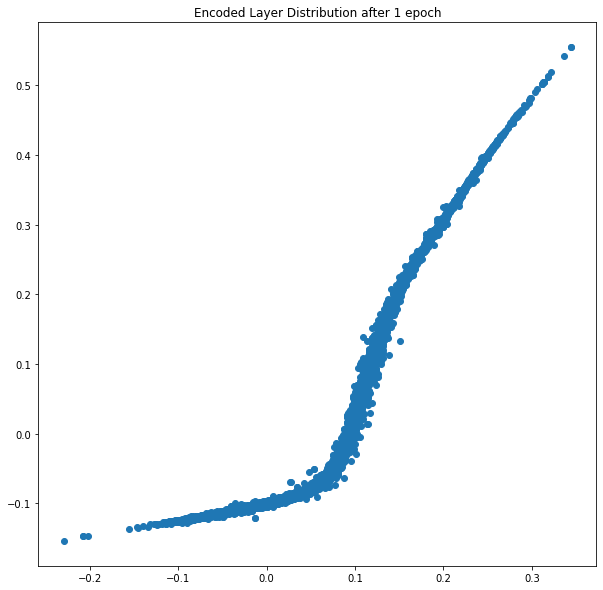

In [28]:
plt.figure(figsize = (10, 10))
plt.scatter(encoded[:, 0], encoded[:, 1])
plt.title('Encoded Layer Distribution after 1 epoch')
plt.show()

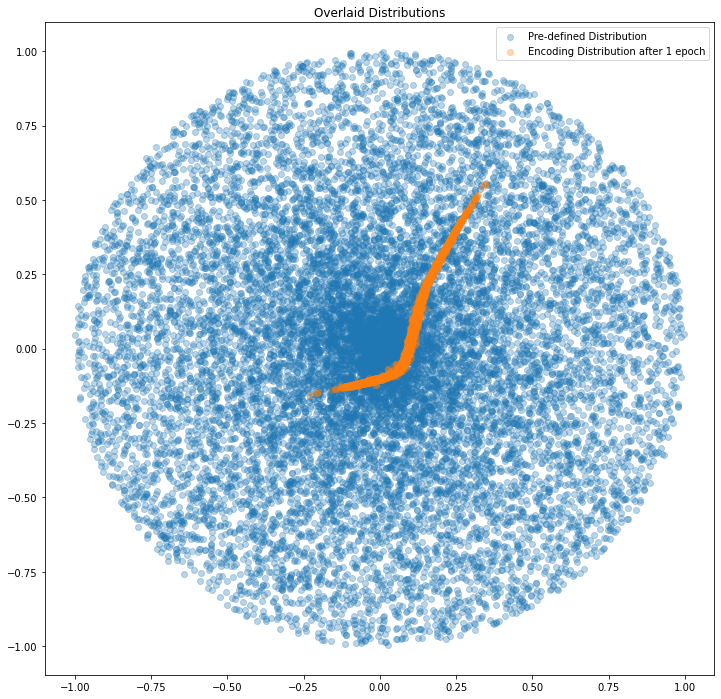

In [29]:
plt.figure(figsize = (12, 12))
plt.scatter(z[:, 0], z[:, 1], alpha = 0.3, label = 'Pre-defined Distribution')
plt.scatter(encoded[:, 0], encoded[:, 1], alpha = 0.3, label = 'Encoding Distribution after 1 epoch')
plt.title('Overlaid Distributions')
plt.legend()
plt.show()

Train on 12800 samples, validate on 3200 samples
Epoch 1/4
12800/12800 [==============================] - 7s 552us/step - loss: 1.5940 - val_loss: 1.7295
Epoch 2/4
12800/12800 [==============================] - 7s 563us/step - loss: 1.2864 - val_loss: 1.1404
Epoch 3/4
12800/12800 [==============================] - 7s 567us/step - loss: 1.0461 - val_loss: 0.7997
Epoch 4/4
12800/12800 [==============================] - 7s 548us/step - loss: 0.9326 - val_loss: 0.7180


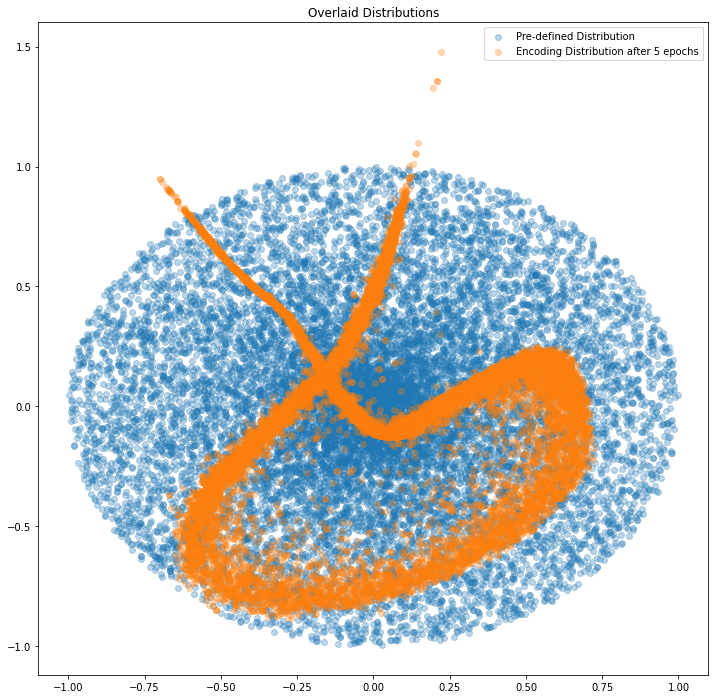

In [30]:
history = autoencoder.fit(X_train, None, validation_split=0.2, epochs = 4, batch_size = 100)
encoded = encoder.predict(X_train)
plt.figure(figsize = (12, 12))
plt.scatter(z[:, 0], z[:, 1], alpha = 0.3, label = 'Pre-defined Distribution')
plt.scatter(encoded[:, 0], encoded[:, 1], alpha = 0.3, label = 'Encoding Distribution after 5 epochs')
plt.title('Overlaid Distributions')
plt.legend()
plt.show()

Train on 12800 samples, validate on 3200 samples
Epoch 1/5
12800/12800 [==============================] - 7s 540us/step - loss: 0.8863 - val_loss: 0.9354
Epoch 2/5
12800/12800 [==============================] - 7s 533us/step - loss: 0.8366 - val_loss: 0.7634
Epoch 3/5
12800/12800 [==============================] - 7s 538us/step - loss: 0.8531 - val_loss: 0.7295
Epoch 4/5
12800/12800 [==============================] - 7s 536us/step - loss: 0.7872 - val_loss: 0.9852
Epoch 5/5
12800/12800 [==============================] - 7s 543us/step - loss: 0.7937 - val_loss: 0.7128


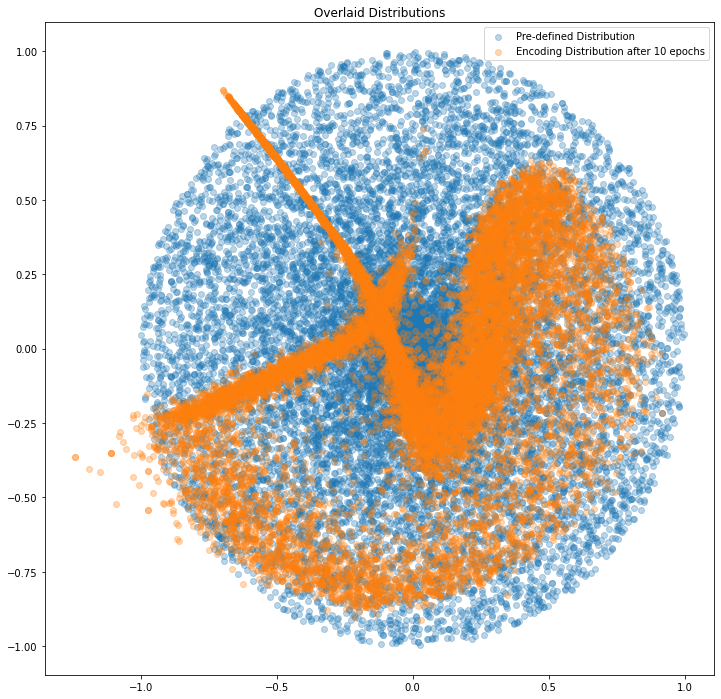

In [31]:
history = autoencoder.fit(X_train, None, validation_split=0.2, epochs = 5, batch_size = 100)
encoded = encoder.predict(X_train)
plt.figure(figsize = (12, 12))
plt.scatter(z[:, 0], z[:, 1], alpha = 0.3, label = 'Pre-defined Distribution')
plt.scatter(encoded[:, 0], encoded[:, 1], alpha = 0.3, label = 'Encoding Distribution after 10 epochs')
plt.title('Overlaid Distributions')
plt.legend()
plt.show()

Train on 12800 samples, validate on 3200 samples
Epoch 1/10
12800/12800 [==============================] - 7s 541us/step - loss: 0.7607 - val_loss: 0.7542
Epoch 2/10
12800/12800 [==============================] - 7s 536us/step - loss: 0.7692 - val_loss: 0.7151
Epoch 3/10
12800/12800 [==============================] - 7s 541us/step - loss: 0.7577 - val_loss: 0.6863
Epoch 4/10
12800/12800 [==============================] - 7s 535us/step - loss: 0.7533 - val_loss: 0.7325
Epoch 5/10
12800/12800 [==============================] - 7s 536us/step - loss: 0.7509 - val_loss: 0.7232
Epoch 6/10
12800/12800 [==============================] - 7s 534us/step - loss: 0.7292 - val_loss: 0.7330
Epoch 7/10
12800/12800 [==============================] - 7s 540us/step - loss: 0.7337 - val_loss: 0.6966
Epoch 8/10
12800/12800 [==============================] - 7s 552us/step - loss: 0.7235 - val_loss: 0.6925
Epoch 9/10
12800/12800 [==============================] - 7s 559us/step - loss: 0.7316 - val_loss: 0.67

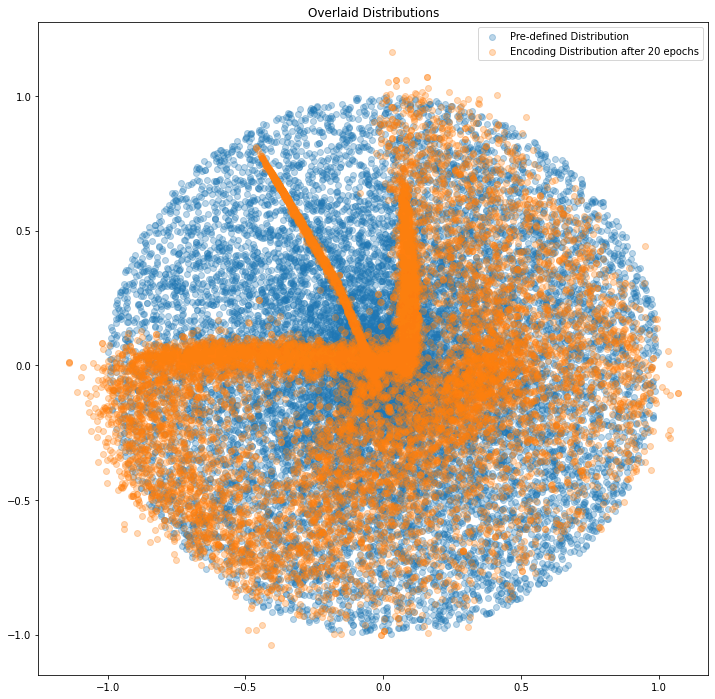

In [32]:
history = autoencoder.fit(X_train, None, validation_split=0.2, epochs = 10, batch_size = 100)
encoded = encoder.predict(X_train)
plt.figure(figsize = (12, 12))
plt.scatter(z[:, 0], z[:, 1], alpha = 0.3, label = 'Pre-defined Distribution')
plt.scatter(encoded[:, 0], encoded[:, 1], alpha = 0.3, label = 'Encoding Distribution after 20 epochs')
plt.title('Overlaid Distributions')
plt.legend()
plt.show()

Train on 12800 samples, validate on 3200 samples
Epoch 1/10
12800/12800 [==============================] - 7s 549us/step - loss: 0.7211 - val_loss: 0.8218
Epoch 2/10
12800/12800 [==============================] - 7s 546us/step - loss: 0.7328 - val_loss: 0.6961
Epoch 3/10
12800/12800 [==============================] - 7s 542us/step - loss: 0.7140 - val_loss: 0.7058
Epoch 4/10
12800/12800 [==============================] - 7s 543us/step - loss: 0.7230 - val_loss: 0.6898
Epoch 5/10
12800/12800 [==============================] - 7s 549us/step - loss: 0.7130 - val_loss: 0.7254
Epoch 6/10
12800/12800 [==============================] - 7s 550us/step - loss: 0.7193 - val_loss: 0.6934
Epoch 7/10
12800/12800 [==============================] - 7s 551us/step - loss: 0.7112 - val_loss: 0.7184
Epoch 8/10
12800/12800 [==============================] - 7s 549us/step - loss: 0.7173 - val_loss: 0.7133
Epoch 9/10
12800/12800 [==============================] - 7s 548us/step - loss: 0.7181 - val_loss: 0.66

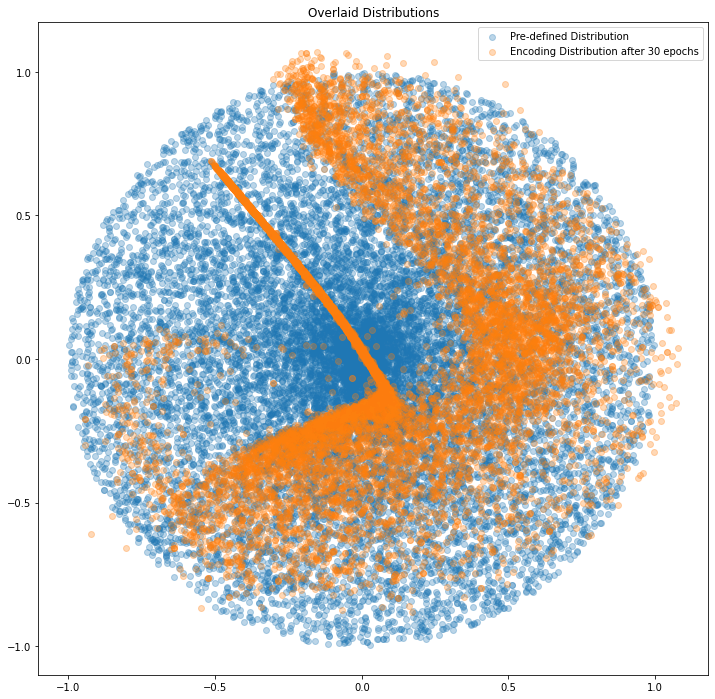

In [33]:
history = autoencoder.fit(X_train, None, validation_split=0.2, epochs = 10, batch_size = 100)
encoded = encoder.predict(X_train)
plt.figure(figsize = (12, 12))
plt.scatter(z[:, 0], z[:, 1], alpha = 0.3, label = 'Pre-defined Distribution')
plt.scatter(encoded[:, 0], encoded[:, 1], alpha = 0.3, label = 'Encoding Distribution after 30 epochs')
plt.title('Overlaid Distributions')
plt.legend()
plt.show()

Train on 12800 samples, validate on 3200 samples
Epoch 1/10
12800/12800 [==============================] - 7s 546us/step - loss: 0.7160 - val_loss: 0.7627
Epoch 2/10
12800/12800 [==============================] - 7s 549us/step - loss: 0.7088 - val_loss: 0.6846
Epoch 3/10
12800/12800 [==============================] - 7s 547us/step - loss: 0.7200 - val_loss: 0.6771
Epoch 4/10
12800/12800 [==============================] - 7s 558us/step - loss: 0.7043 - val_loss: 0.6744
Epoch 5/10
12800/12800 [==============================] - 7s 565us/step - loss: 0.7189 - val_loss: 0.7207
Epoch 6/10
12800/12800 [==============================] - 7s 548us/step - loss: 0.7018 - val_loss: 0.6676
Epoch 7/10
12800/12800 [==============================] - 7s 535us/step - loss: 0.7143 - val_loss: 0.7615
Epoch 8/10
12800/12800 [==============================] - 7s 538us/step - loss: 0.7077 - val_loss: 0.6759
Epoch 9/10
12800/12800 [==============================] - 7s 538us/step - loss: 0.7057 - val_loss: 0.65

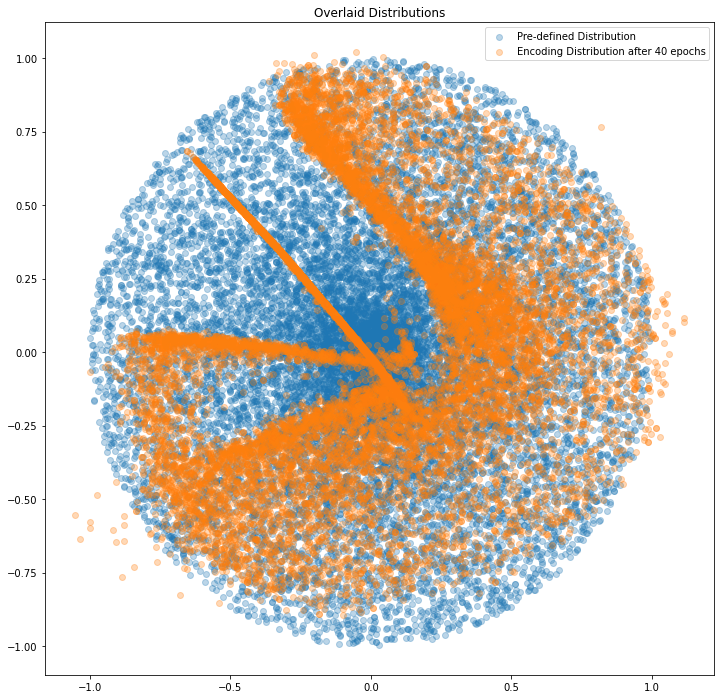

In [34]:
history = autoencoder.fit(X_train, None, validation_split=0.2, epochs = 10, batch_size = 100)
encoded = encoder.predict(X_train)
plt.figure(figsize = (12, 12))
plt.scatter(z[:, 0], z[:, 1], alpha = 0.3, label = 'Pre-defined Distribution')
plt.scatter(encoded[:, 0], encoded[:, 1], alpha = 0.3, label = 'Encoding Distribution after 40 epochs')
plt.title('Overlaid Distributions')
plt.legend()
plt.show()

Train on 12800 samples, validate on 3200 samples
Epoch 1/10
12800/12800 [==============================] - 7s 533us/step - loss: 0.6966 - val_loss: 0.6750
Epoch 2/10
12800/12800 [==============================] - 7s 532us/step - loss: 0.7162 - val_loss: 0.7181
Epoch 3/10
12800/12800 [==============================] - 7s 537us/step - loss: 0.7103 - val_loss: 0.6883
Epoch 4/10
12800/12800 [==============================] - 7s 533us/step - loss: 0.6976 - val_loss: 0.6950
Epoch 5/10
12800/12800 [==============================] - 7s 535us/step - loss: 0.7007 - val_loss: 0.6948
Epoch 6/10
12800/12800 [==============================] - 7s 532us/step - loss: 0.6955 - val_loss: 0.7198
Epoch 7/10
12800/12800 [==============================] - 7s 533us/step - loss: 0.7016 - val_loss: 0.6806
Epoch 8/10
12800/12800 [==============================] - 7s 534us/step - loss: 0.7019 - val_loss: 0.6958
Epoch 9/10
12800/12800 [==============================] - 7s 534us/step - loss: 0.6942 - val_loss: 0.70

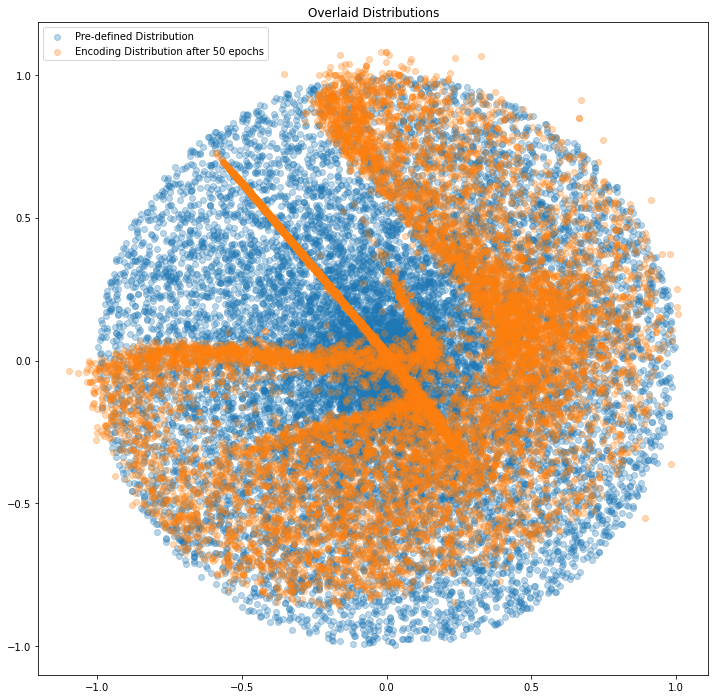

In [35]:
history = autoencoder.fit(X_train, None, validation_split=0.2, epochs = 10, batch_size = 100)
encoded = encoder.predict(X_train)
plt.figure(figsize = (12, 12))
plt.scatter(z[:, 0], z[:, 1], alpha = 0.3, label = 'Pre-defined Distribution')
plt.scatter(encoded[:, 0], encoded[:, 1], alpha = 0.3, label = 'Encoding Distribution after 50 epochs')
plt.title('Overlaid Distributions')
plt.legend()
plt.show()